In [1]:
# imports, ARIMA model is the choice today
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
#datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
oil_df = pd.read_csv('oil.csv')
holidays_df = pd.read_csv('holidays_events.csv')
stores_df = pd.read_csv('stores.csv')

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
# merge datasets
train_df = pd.merge(train_df, oil_df, how='left', on='date')
train_df = pd.merge(train_df, stores_df, how='left', on='store_nbr')
holidays_df.rename(columns={'type': 'holidays_type'}, inplace=True)
train_df = pd.merge(train_df, holidays_df, how='left', on='date')


In [9]:
# delete unnecessary dataframes
del holidays_df, oil_df, stores_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             int64  
 1   date           object 
 2   store_nbr      int64  
 3   family         object 
 4   sales          float64
 5   onpromotion    int64  
 6   dcoilwtico     float64
 7   city           object 
 8   state          object 
 9   type           object 
 10  cluster        int64  
 11  holidays_type  object 
 12  locale         object 
 13  locale_name    object 
 14  description    object 
 15  transferred    object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB


In [10]:
# Any null?
train_df.isnull().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
dcoilwtico        955152
city                   0
state                  0
type                   0
cluster                0
holidays_type    2551824
locale           2551824
locale_name      2551824
description      2551824
transferred      2551824
dtype: int64

In [55]:
# see percent of missing value
train_df.isnull().sum() / train_df.shape[0]

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
dcoilwtico       0.312719
city             0.000000
state            0.000000
type             0.000000
cluster          0.000000
holidays_type    0.835473
locale           0.835473
locale_name      0.835473
description      0.835473
transferred      0.835473
dtype: float64

In [11]:
# Exclude the columns that have an 80% null percentage
null_percent = train_df.isnull().sum() / train_df.shape[0]
null_80_column = null_percent[null_percent > 0.8].index
train_df = train_df.drop(columns=null_80_column, axis=1)

In [12]:
train_df['dcoilwtico'].describe()

count    2.099196e+06
mean     6.801587e+01
std      2.569134e+01
min      2.619000e+01
25%      4.641000e+01
50%      5.343000e+01
75%      9.581000e+01
max      1.106200e+02
Name: dcoilwtico, dtype: float64

In [13]:
# Fill mode for dcoilwtico
train_df['dcoilwtico'] = train_df['dcoilwtico'].fillna(train_df['dcoilwtico'].mode()[0])

In [14]:
# duplicated row view
train_df = train_df.drop(columns=['id'], axis=1)
train_df.duplicated().any()

True

In [15]:
train_df.duplicated().sum()

53460

In [16]:
# delete duplicated rows
train_df = train_df.drop_duplicates()

In [17]:
train_df.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
type           0
cluster        0
dtype: int64

# Now it's time to check out some of the stats from the data

Text(0.5, 1.0, 'The highest Sales by product Family, top 10')

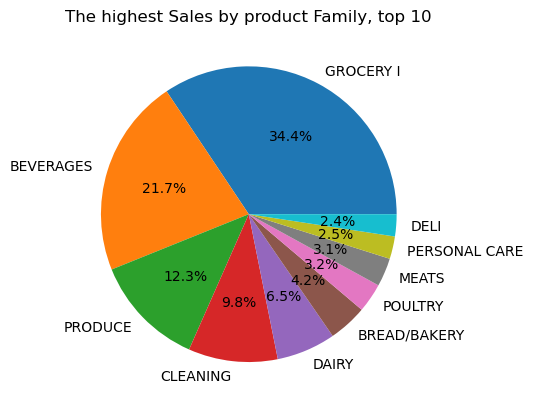

In [21]:
# Which sales family generates the highest sales revenue
family_sales_group = train_df.groupby(by=['family'])['sales'].sum()
family_sales_group = family_sales_group.sort_values(ascending=False)
plt.pie(family_sales_group[:10], labels=family_sales_group[:10].index, autopct='%1.1f%%')
plt.title('The highest Sales by product Family, top 10')
# Discovery: GROCERY family has the highest sales revenue

Text(0.5, 1.0, 'The highest Sales by State, top 10')

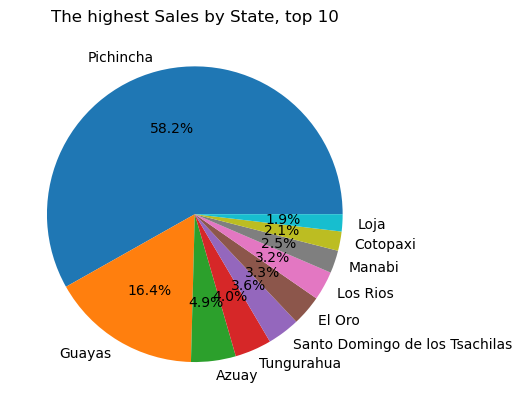

In [22]:
# Which state has the highest sales revenue
state_sales_group = train_df.groupby(by=['state'])['sales'].sum()
state_sales_group = state_sales_group.sort_values(ascending=False)
plt.pie(state_sales_group[:10], labels=state_sales_group[:10].index, autopct='%1.1f%%')
plt.title('The highest Sales by State, top 10')
# Discovery: Pichincha has the highest proportion of cities,

Text(0.5, 1.0, 'The Sales Distribution for Each State')

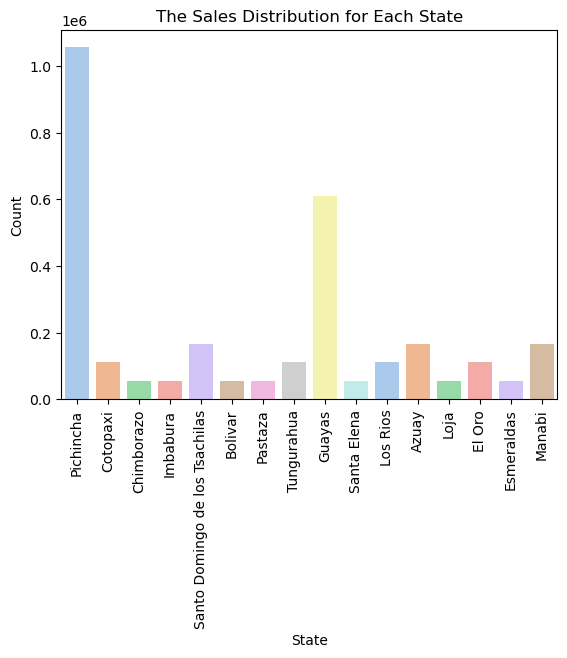

In [24]:
# Which state has the most customers
ax = sns.countplot(train_df, x='state', palette=sns.color_palette('pastel'))
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('The Sales Distribution for Each State')
# Discovery: Of course, Pichincha and Guayas have the most


Text(0.5, 1.0, 'The highest Sales by City of top 10')

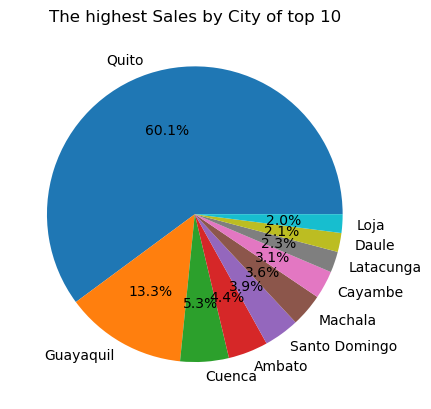

In [25]:
# Which city has the highest sales volume
city_sales_group = train_df.groupby(by=['city'])['sales'].sum()
city_sales_group = city_sales_group.sort_values(ascending=False)
plt.pie(city_sales_group[:10], labels=city_sales_group[:10].index, autopct='%1.1f%%')
plt.title('The highest Sales by City of top 10')
# Discovery: Quito has the highest sales volume

Text(0.5, 1.0, 'The Sales Distribution for Each City')

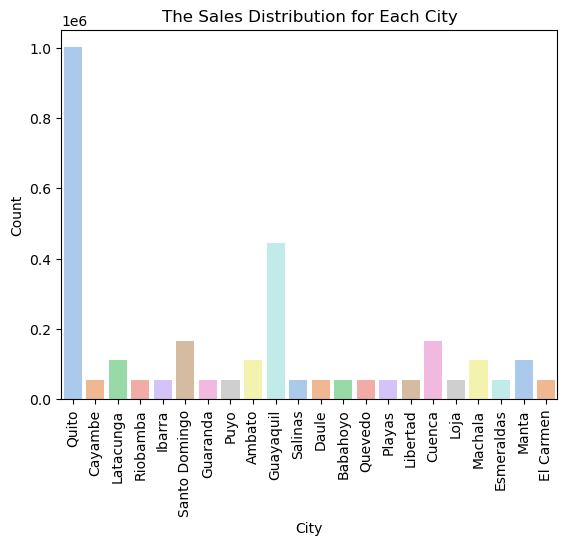

In [26]:
# Which city has the most customers
ax = sns.countplot(train_df, x='city', palette=sns.color_palette('pastel'))
ax.set_xlabel('City')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('The Sales Distribution for Each City')
# Discovery: Quito remains the highest


Text(0.5, 1.0, 'Sum of On Promotion Distribution for Each store')

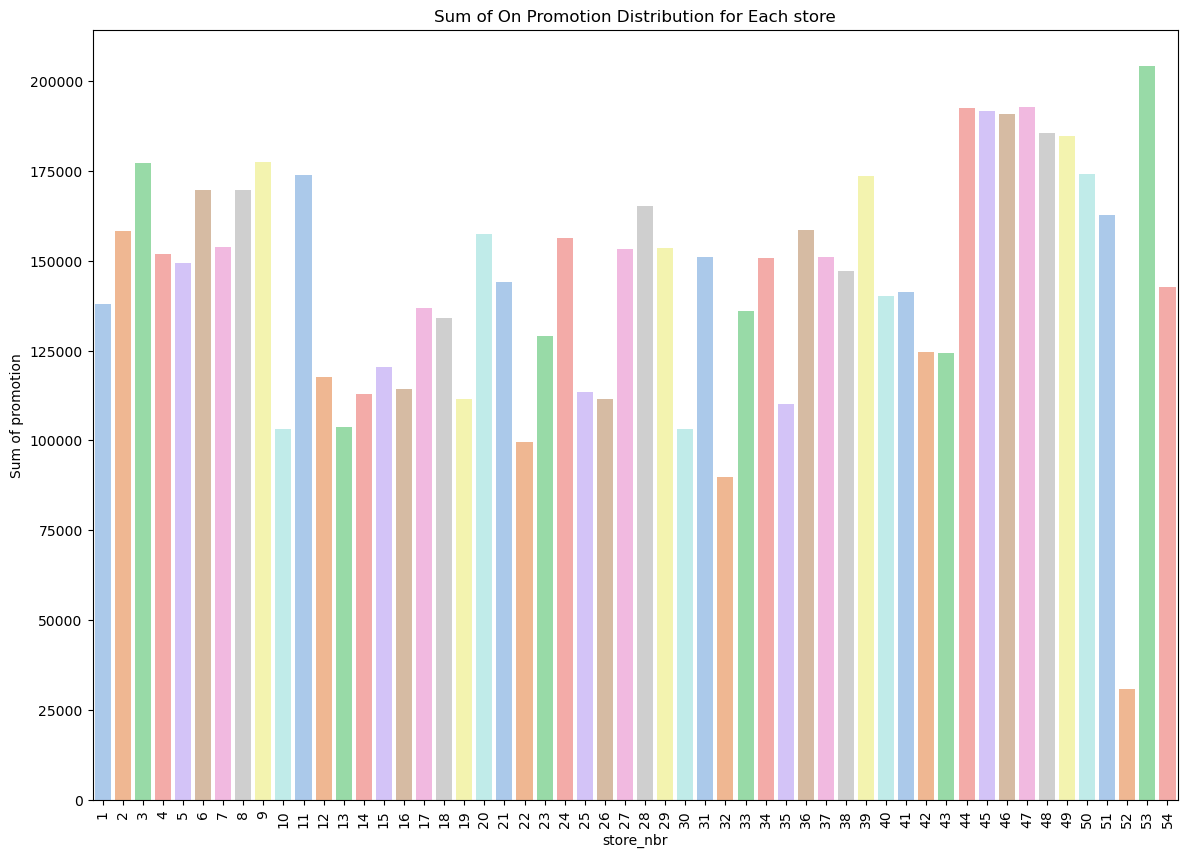

In [27]:
# Which store has the highest number of promotional products
plt.figure(figsize=(14, 10))
onpromotion_sum_group = train_df.groupby(by=['store_nbr'])['onpromotion'].sum().reset_index()
ax = sns.barplot(onpromotion_sum_group, x='store_nbr', y='onpromotion', palette=sns.color_palette('pastel'))
ax.set_xlabel('store_nbr')
ax.set_ylabel('Sum of promotion')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Sum of On Promotion Distribution for Each store')


Text(0.5, 1.0, 'Relationship of Promotion and Sales')

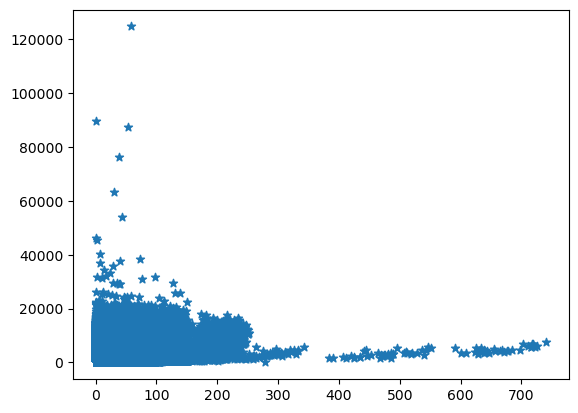

In [28]:
# The relationship between the quantity of promotional products and sales revenue
plt.scatter(train_df['onpromotion'], train_df['sales'], marker='*')
ax.set_xlabel('On Promotion')
ax.set_ylabel('Sales')
ax.set_title('Relationship of Promotion and Sales')
# Discovery: The more promotional products, the less likely an increase in sales is going to be seen

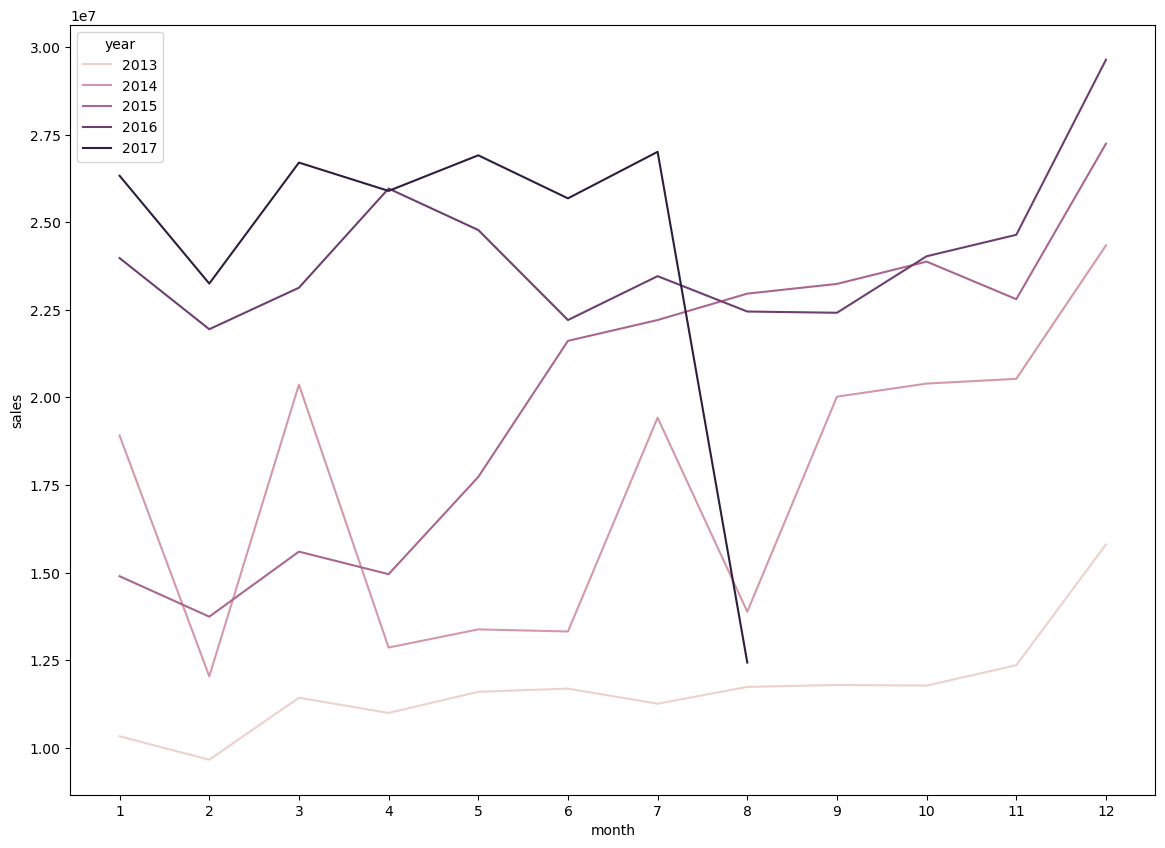

In [29]:
# Annual Sales Comparison


# Build year and month columns
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

# Group Statistics
month_sales_group = train_df.groupby(by=['year', 'month'])['sales'].sum()
pd.DataFrame(month_sales_group)

# Plot time
plt.figure(figsize=(14, 10))
ax = sns.lineplot(pd.DataFrame(month_sales_group), x='month', y='sales', hue='year')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(1, 13), labels=list(range(1, 13)))

In [30]:
# Merge by date
train_df = train_df.groupby(by=['date'])['sales', 'onpromotion'].sum().reset_index()

C:\Users\s3327\AppData\Local\Temp\ipykernel_18808\1109501571.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_df = train_df.groupby(by=['date'])['sales', 'onpromotion'].sum().reset_index()


<Axes: xlabel='date'>

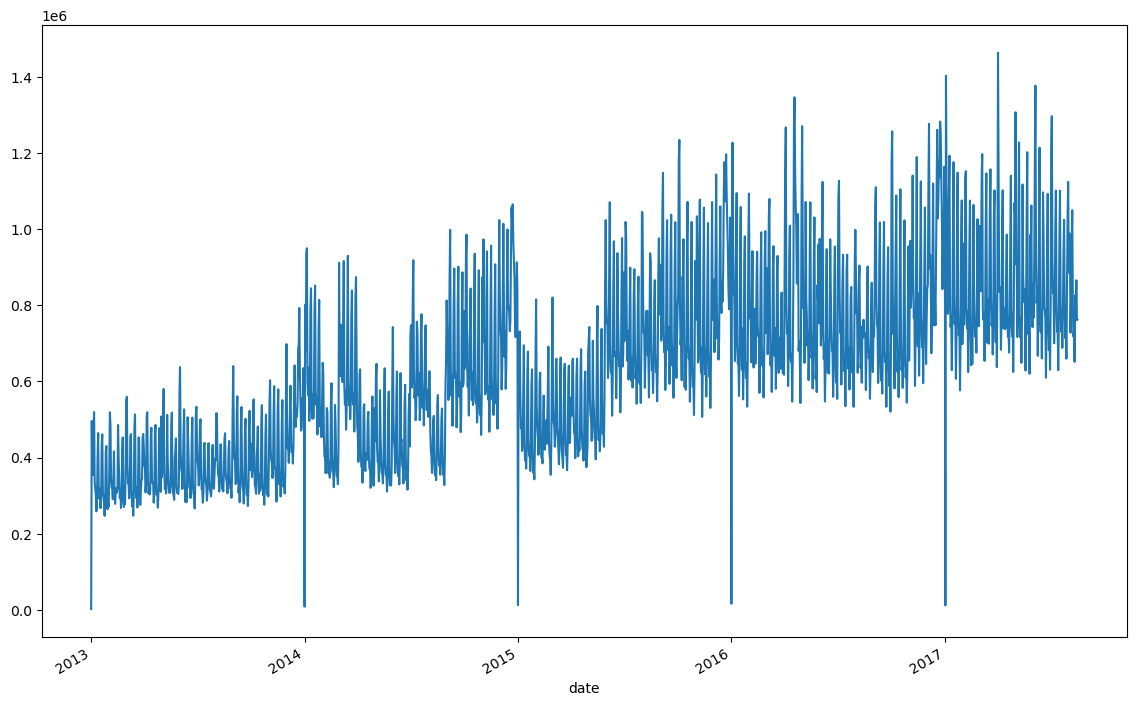

In [31]:
# Draw a time series diagram 
train_df.index = train_df['date']
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
train_df['sales'].plot(color='C0', ax=ax)

# Discovery: There is a clear trend

In [35]:
# 1-diff
train_df['diff_sales'] = train_df['sales'].diff(1)
train_df = train_df.dropna()

In [36]:
# Perform ADF test to verify stationarity
# Is sequence stationary?
adf_result = adfuller(train_df['diff_sales'])
print(f'p-value:{adf_result[1]}')
# If the p-value is below the significance level (e.g., 0.05), the sequence is considered stationary
# Based on the obtained p-value, the sequence is already stationary at this point in time

p-value:4.573768417345788e-21


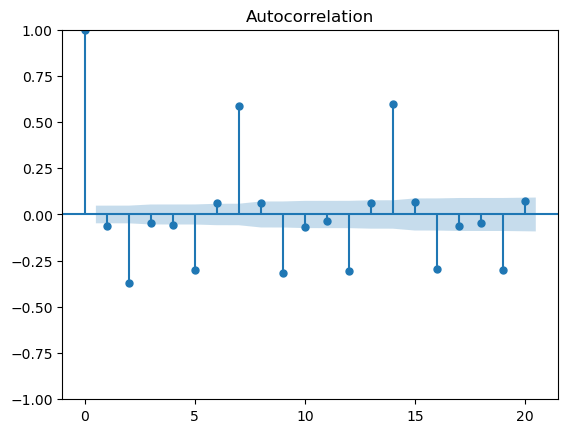

In [37]:
# auto correlation diagram
tsaplots.plot_acf(train_df['diff_sales'], lags=20)
plt.show()
# Trailing, but with truncation, for simplicity, simply select q value=1

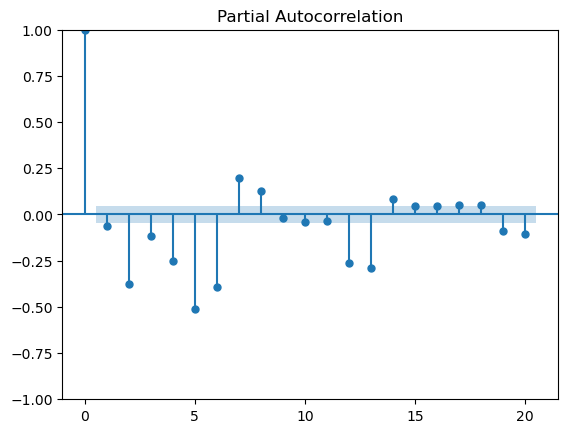

In [42]:
tsaplots.plot_pacf(train_df['diff_sales'], lags=20, method='ywm')
plt.show()

In [39]:
# Using the above content, building a model
arima_model = ARIMA(train_df['diff_sales'], order=(2, 1, 1)).fit()
arima_model.summary()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             diff_sales   No. Observations:                 1683
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -22481.364
Date:                Sun, 28 May 2023   AIC                          44970.727
Time:                        20:48:54   BIC                          44992.438
Sample:                             0   HQIC                         44978.769
                               - 1683                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0848      0.023     -3.693      0.000      -0.130      -0.040
ar.L2         -0.3752      0.025    -14.764      0.000      -0.425      -0.325
ma.L1         -0.9993      0.032    -31.069      0.000      -1.062      -0.936
sigma2      3.382e+10   7.15e-13   4.73e+22      0.000    3.38e+10    3.38e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.10   Jarque-Bera (JB):              3003.26
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+37. Standard errors may be unstable.
"""

In [40]:
# Complete prediction of train_df and test_df
start = train_df.shape[0]
end = train_df.shape[0] + test_df.shape[0] - 1
prediction_value = arima_model.predict(start=start, end=end)
prediction_value

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1683     39623.306489
1684     -3529.282032
1685    -14080.540269
1686      3003.813831
1687      5512.724460
             ...     
30190      332.271814
30191      332.271814
30192      332.271814
30193      332.271814
30194      332.271814
Name: predicted_mean, Length: 28512, dtype: float64

In [41]:
# Calculate error between train_df and predicted values of ARIMA model
prediction_value = prediction_value[:len(train_df['diff_sales'])]
mae = np.mean(np.abs(prediction_value.values - train_df['diff_sales'].values))
mse = np.mean((prediction_value.values - train_df['diff_sales'].values) ** 2)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 116267.2125960065
MSE: 25537153036.72316
RMSE: 159803.4825550531
